<a href="https://colab.research.google.com/github/ErsyaHasby/Belajar-database/blob/main/Demo_Index_SQLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sqlite3
import time
import os
import psutil
import matplotlib.pyplot as plt

In [ ]:
# --- Helper: cek penggunaan memori ---
def show_memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 * 1024)  # MB
    print(f"Memory used: {mem:.2f} MB")

In [ ]:
# --- 1. Buat database di file (disk) ---
db_name = "test_db.sqlite"
if os.path.exists(db_name):
    os.remove(db_name)  # hapus kalau sudah ada sebelumnya

conn = sqlite3.connect(db_name)
cursor = conn.cursor()

In [ ]:
# --- 2. Buat tabel & isi data besar ---
cursor.execute("CREATE TABLE users (id INTEGER PRIMARY KEY, name TEXT, age INTEGER)")
conn.commit()

print("Mengisi data besar (200k baris)...")
cursor.executemany(
    "INSERT INTO users (name, age) VALUES (?, ?)",
    [(f"user_{i}", i % 100) for i in range(200000)]  # 200 ribu data
)
conn.commit()
print("✅ Database selesai dibuat.")

Mengisi data besar (200k baris)...
✅ Database selesai dibuat.


In [ ]:
# Simpan hasil waktu eksekusi
times = {}

In [ ]:
# --- 3. Query tanpa index ---
show_memory_usage()
start = time.time()
cursor.execute("SELECT * FROM users WHERE age = 50")
rows = cursor.fetchall()
end = time.time()
times["Tanpa Index"] = end - start
print(f"Query tanpa index: {end - start:.4f} detik, hasil {len(rows)} baris")
show_memory_usage()

Memory used: 100.98 MB
Query tanpa index: 0.0164 detik, hasil 2000 baris
Memory used: 100.98 MB


In [ ]:
# --- 4. Tambahkan index ---
cursor.execute("CREATE INDEX idx_age ON users(age)")
conn.commit()

# Query dengan index
start = time.time()
cursor.execute("SELECT * FROM users WHERE age = 50")
rows = cursor.fetchall()
end = time.time()
times["Dengan Index"] = end - start
print(f"Query dengan index: {end - start:.6f} detik, hasil {len(rows)} baris")
show_memory_usage()

Query dengan index: 0.008798 detik, hasil 2000 baris
Memory used: 102.43 MB


In [ ]:
# --- 5. Query berulang (cache di RAM) ---
cached_times = []
for i in range(3):
    start = time.time()
    cursor.execute("SELECT * FROM users WHERE age = 50")
    rows = cursor.fetchall()
    end = time.time()
    duration = end - start
    cached_times.append(duration)
    print(f"Query ke-{i+1} (cached): {duration:.6f} detik")

times["Cached (avg)"] = sum(cached_times) / len(cached_times)

conn.close()

Query ke-1 (cached): 0.007050 detik
Query ke-2 (cached): 0.004631 detik
Query ke-3 (cached): 0.004161 detik


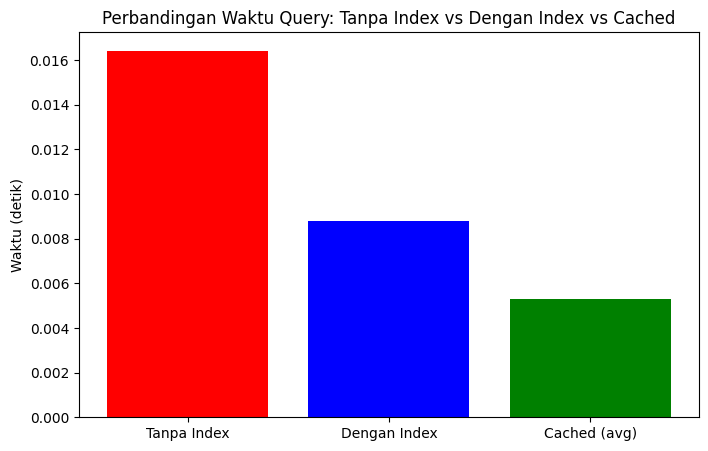

In [ ]:
# --- 6. Visualisasi ---
labels = list(times.keys())
values = list(times.values())

plt.figure(figsize=(8,5))
plt.bar(labels, values, color=['red', 'blue', 'green'])
plt.ylabel("Waktu (detik)")
plt.title("Perbandingan Waktu Query: Tanpa Index vs Dengan Index vs Cached")
plt.show()